In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as sopt
from mindquantum.simulator import Simulator
from mindquantum.core import CNOT, H, X, Z, RX, RY, RZ, Circuit, QubitOperator, PhaseShift, Hamiltonian
import matplotlib as mpl
import matplotlib.pyplot as plt

/home/ubuntu/miniconda3/lib/python3.8/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Disable mqvector gpu backend due to: Malloc GPU memory failed: cudaErrorInsufficientDriver, CUDA driver version is insufficient for CUDA runtime version
  from .available_simulator import SUPPORTED_SIMULATOR
/home/ubuntu/miniconda3/lib/python3.8/site-packages/mindquantum/__init__.py:28: UserWarning: MindSpore not installed, you may not be able to use hybrid quantum classical neural network.
  from . import (


In [2]:
def entangling_gate(parameter, qubits):
    circuit = Circuit()
    circuit += RZ(-np.pi / 2).on(qubits[1])
    circuit += CNOT.on(qubits[0], qubits[1])
    circuit += RZ({parameter: -2}).on(qubits[0])
    circuit += RZ(np.pi / 2).on(qubits[0])
    circuit += RY({parameter: 2}).on(qubits[1])
    circuit += RY(-np.pi / 2).on(qubits[1])
    circuit += CNOT.on(qubits[1], qubits[0])
    circuit += RY({parameter: -2}).on(qubits[1])
    circuit += RY(np.pi / 2).on(qubits[1])
    circuit += CNOT.on(qubits[0], qubits[1])
    circuit += RZ(np.pi / 2).on(qubits[0])
    return circuit

def ansatz(N, layers, local_rot=True):
    circuit = Circuit()
    params_index = 0
    for layer_index in range(layers):
        for i in range(2):
            for j in range(i, N - 1, 2):
                circuit += entangling_gate(str(params_index), [j, j + 1])
                params_index += 1
        if local_rot:
            for i in range(N):
                circuit += PhaseShift(str(params_index)).on(i)
                params_index += 1
    return circuit

In [3]:
def init_block(init_str):
    circ = Circuit()
    for i, c in enumerate(init_str):
        if c == '1':
            circ += X(i)
    return circ

In [4]:
class SSVQE:
    def __init__(self, n_qubits, init_circuits, pqc, ops, beta):
        self.n_qubits = n_qubits
        self.circs = [circ + pqc for circ in init_circuits]
        self.sim = Simulator('mqvector', n_qubits)
        self.beta = beta
        self.grad_ops = [self.sim.get_expectation_with_grad(ops, circ) for circ in self.circs]

    def energy(self, params):
        if self.sim is None:
            self.sim = Simulator('mqvector', self.n_qubits)
        energies = []
        for i in range(len(self.grad_ops)):
            f, g = self.grad_ops[i](params)
            energies.append(f[0, 0].real)
        return energies

    def __call__(self, inputs):
        cost = 0
        cost_grad = 0
        for i in range(len(self.grad_ops)):
            f, g = self.grad_ops[i](inputs)
            f1, f2, f3 = f[0, 0].real, f[0, 1].real, f[0, 2].real
            g1, g2, g3 = np.array(g[0, 0, :].real), np.array(g[0, 1, :].real), np.array(g[0, 2, :].real)
            cost += (f1 + self.beta * (f2 + f3)) * (len(self.grad_ops) - i)
            cost_grad += (g1 + self.beta * (g2 + g3)) * (len(self.grad_ops) - i)
        return cost, cost_grad

In [5]:
def s_alpha(N, alpha: str = 'X'):
    alpha = alpha.upper()
    out = QubitOperator()
    for i in range(N):
        out += QubitOperator(alpha + f'{i}')
    return out * 0.5

def s_tot_op(N):
    s_x_op = s_alpha(N, 'X')**2
    s_y_op = s_alpha(N, 'Y')**2
    s_z_op = s_alpha(N, 'Z')**2
    op = s_x_op + s_y_op + s_z_op
    op.compress()
    return op

def ham_heis(n_qubits, J):
    ham = QubitOperator()
    for i in range(1, n_qubits):
        ham += QubitOperator("X{} X{}".format(i - 1, i), J)
        ham += QubitOperator("Y{} Y{}".format(i - 1, i), J)
        ham += QubitOperator("Z{} Z{}".format(i - 1, i), J)
    ham.compress()
    return Hamiltonian(ham)


In [6]:
n_qubits = 4
layers = 6
target_value = 0
pqc = ansatz(n_qubits, layers, local_rot=True)
init_circuits = [init_block(s) for s in ['0101', '1010']]
s_tot = s_tot_op(n_qubits)
pen_op1 = Hamiltonian(s_tot ** 2)
pen_op2 = Hamiltonian(-2 * target_value * s_tot)
ham = ham_heis(n_qubits, J=1)
ssvqe = SSVQE(n_qubits=n_qubits, init_circuits=init_circuits, pqc=pqc, ops=[ham, pen_op1, pen_op2], beta=2)

In [7]:
results = [0, 0, 0, 0]

In [8]:
np.random.seed(142)
initial_parameter = (np.random.rand(len(ssvqe.circs[0].params_name)) - .5) * np.pi
res = sopt.minimize(ssvqe,
                    initial_parameter,
                    method='l-bfgs-b',
                    jac=True,
                    options={'disp': False})
results[0], results[3] = ssvqe.energy(res.x)

In [9]:
target_value = 2
pen_op2 = Hamiltonian(-2 * target_value * s_tot)
ssvqe = SSVQE(n_qubits=n_qubits, init_circuits=init_circuits, pqc=pqc, ops=[ham, pen_op1, pen_op2], beta=2)

initial_parameter = (np.random.rand(len(ssvqe.circs[0].params_name)) - .5) * np.pi
res = sopt.minimize(ssvqe,
                    initial_parameter,
                    method='l-bfgs-b',
                    jac=True,
                    options={'disp': False})
results[1], results[2] = ssvqe.energy(res.x)

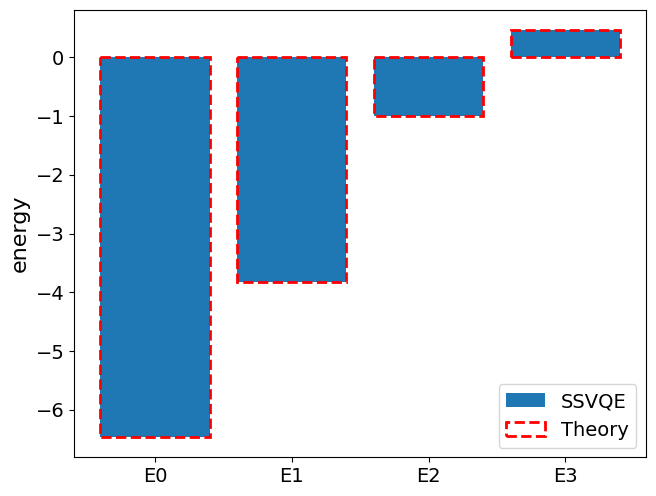

In [10]:
mpl.rc('font',size=14)
mpl.rc('axes',labelsize=16)
theo_result = [-6.464101615137754, -3.8284271247461867, -1, 0.4641016151377547]
tick_label = ['E0', 'E1', 'E2', 'E3']
plt.bar(np.arange(len(results)), results, width=0.8, label='SSVQE')
plt.bar(range(len(results)), theo_result[:len(results)], width=0.8, ec='red', ls='--', lw=2, fill='', label='Theory', tick_label=tick_label[:len(results)])
plt.legend()
plt.ylabel('energy')
plt.tight_layout(pad=.1)
plt.savefig('result.png', dpi=400)